In [ ]:
from astropy.io import fits
import numpy as np
import sep
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
fits_file_path = r'C:\UCSC-Sam\numpy_project\Astr19\hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits'
# Open the FITS file
hdul = fits.open(fits_file_path)
data = hdul[0].data
data = data.byteswap().newbyteorder()

In [ ]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
# plt.savefig("pic_1.png",bbox_inches='tight')

In [ ]:
bkg = sep.Background(data)
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)


In [ ]:
print(bkg.globalback)
print(bkg.globalrms)

In [ ]:
bkg_image = bkg.back()

In [ ]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
# plt.savefig("pic_2.png",bbox_inches='tight')

In [ ]:
bkg_rms = bkg.rms()

In [ ]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
# plt.savefig("pic_3.png",bbox_inches='tight')

In [ ]:
data_sub = data - bkg

In [ ]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

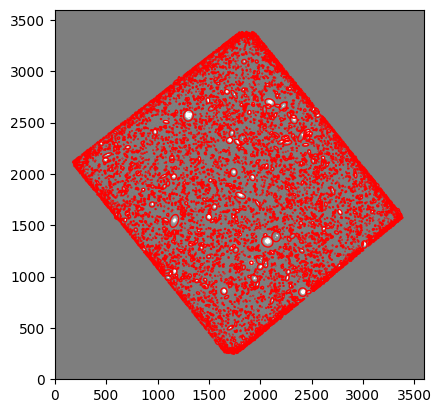

In [52]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [ ]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'], 3.0, err=bkg.globalrms, gain=1.0)

In [ ]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

In [ ]:
positive_flux = flux[flux > 0]  # Filter out non-positive flux values
plt.figure(figsize=(10, 6))
plt.hist(positive_flux, bins=100, color='black', alpha=0.7)  # Adjust number of bins as needed
plt.title('Histogram of Detected Objects\' Positive Fluxes')
plt.xlabel('Flux')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale for the y-axis to better visualize a wide range of values
plt.grid(True)
plt.show()


In [ ]:
mean_flux = np.mean(flux)
median_flux = np.median(flux)
std_flux = np.std(flux)
largest_outlier_flux = np.max(flux)
outlier_index = np.argmax(flux)
outlier_position = (objects['x'][outlier_index], objects['y'][outlier_index])
outlier_stddevs_away = (largest_outlier_flux - mean_flux) / std_flux

print(f"Mean Flux: {mean_flux}")
print(f"Median Flux: {median_flux}")
print(f"Standard Deviation of Flux: {std_flux}")
print(f"Largest Outlier Flux: {largest_outlier_flux}, Position: {outlier_position}, {outlier_stddevs_away} Standard Deviations away from the mean")


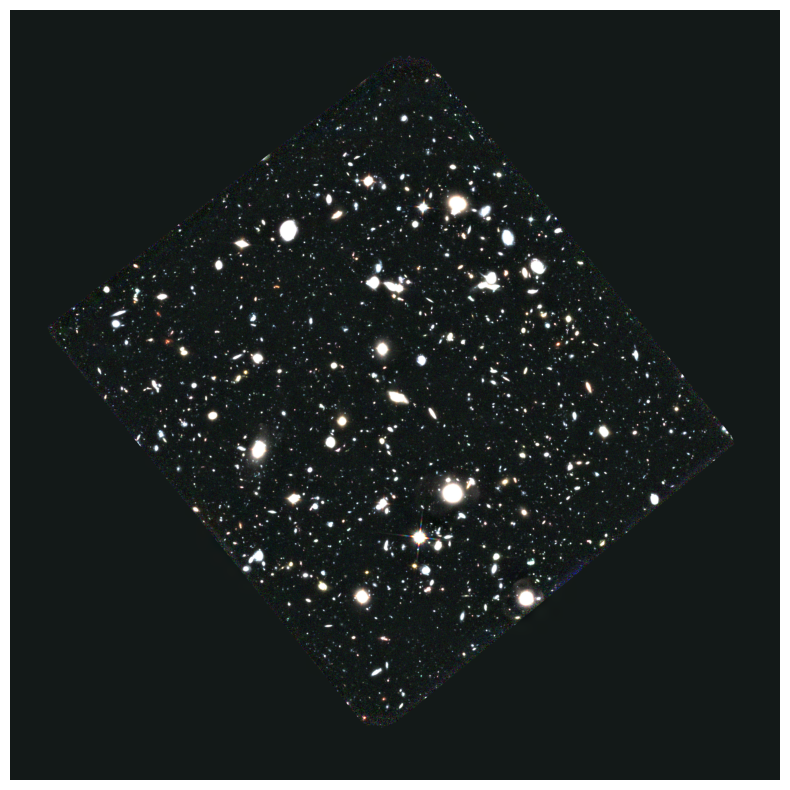

In [55]:
# Paths to the f125w and f160w FITS files
f125w_path = r'C:\UCSC-Sam\numpy_project\Astr19\hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits'
f160w_path = r'C:\UCSC-Sam\numpy_project\Astr19\hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits'

# Load the FITS files
with fits.open(f125w_path) as hdul:
    f125w_data = hdul[0].data.byteswap().newbyteorder()
with fits.open(f160w_path) as hdul:
    f160w_data = hdul[0].data.byteswap().newbyteorder()

# Subtract the background for each image
bkg_f125w = sep.Background(f125w_data)
f125w_sub = f125w_data - bkg_f125w.back()
bkg_f160w = sep.Background(f160w_data)
f160w_sub = f160w_data - bkg_f160w.back()

# Use a percentile for normalization to avoid the influence of extreme values
p1, p99 = np.percentile(f160w_sub, (1, 99))
f160w_norm = np.clip((f160w_sub - p1) / (p99 - p1), 0, 1)

p1, p99 = np.percentile(f125w_sub, (1, 99))
f125w_norm = np.clip((f125w_sub - p1) / (p99 - p1), 0, 1)

p1, p99 = np.percentile(data_sub, (1, 99))  # Assuming 'data_sub' is from f105w data
f105w_norm = np.clip((data_sub - p1) / (p99 - p1), 0, 1)

# Now create the RGB image
rgb_image = np.zeros((f160w_sub.shape[0], f160w_sub.shape[1], 3), dtype=float)
rgb_image[..., 0] = f160w_norm  # Red channel
rgb_image[..., 1] = f125w_norm  # Green channel
rgb_image[..., 2] = f105w_norm  # Blue channel

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image, origin='lower')
plt.axis('off')
plt.show()


In [53]:
print(np.min(f160w_sub), np.max(f160w_sub))
print(np.min(f125w_sub), np.max(f125w_sub))
print(np.min(data_sub), np.max(data_sub))


-0.009378918 56.834644
-0.010166801 70.191444
-0.9047286 74.44604
